In [1]:
import numpy as np
import struct as struct
from struct import unpack
import matplotlib.pyplot as plt 
from scipy.sparse import csr_array
import time

conf is a list where each entry contains 18 real double numbers that represent the gauge link $U_\mu(x)\in$ SU(3). The configuration layout is the following:

```python
cont = 0for t in range(Nt):
    for z in range(Nz):
        for y in range(Ny):
            for x in range(Nx):
                for m in range(4):
                    U[t,z,y,x,mu] = conf[cont] #This is an array with 18 numbers
                    cont += 1f
```

```
  U[ 0] = creal( SU3[0][0] );     U[ 1] = cimag( SU3[0][0] );
  U[ 2] = creal( SU3[1][0] );     U[ 3] = cimag( SU3[1][0] );
  U[ 4] = creal( SU3[2][0] );     U[ 5] = cimag( SU3[2][0] );
  
  U[ 6] = creal( SU3[0][1] );     U[ 7] = cimag( SU3[0][1] );
  U[ 8] = creal( SU3[1][1] );     U[ 9] = cimag( SU3[1][1] );
  U[10] = creal( SU3[2][1] );     U[11] = cimag( SU3[2][1] );
  
  U[12] = creal( SU3[0][2] );     U[13] = cimag( SU3[0][2] );
  U[14] = creal( SU3[1][2] );     U[15] = cimag( SU3[1][2] );
  U[16] = creal( SU3[2][2] );     U[17] = cimag( SU3[2][2] );
```

In [4]:
def SU3mat(U):
    SU3 = np.zeros((3,3),dtype=complex)
    for i in range(3):
        for j in range(3):
            SU3[i,j] = U[2*(i+j*3)] + 1j*U[2*(i+j*3)+1]
    return SU3

In [5]:
Nt, Nz, Ny, Nx = 4, 4, 4, 4
filename = '{0}x{1}x{2}x{3}_random'.format(Nt,Nz,Ny,Nx)
conf = []
count = 0
with open(filename, "rb") as f:
    while True:
        if count == 0:
            struct_fmt = '=4id' 
            struct_len = struct.calcsize(struct_fmt)
            struct_unpack = struct.Struct(struct_fmt).unpack_from #reads lattice dimensions and plaquete 0.0
            count += 1
            data = f.read(struct_len)
            s = struct_unpack(data)
            print('Lattice dimensions Nt={0}, Nz={1}, Ny={2}, Nx={3}'.format(s[0],s[1],s[2],s[3]))
        elif count == 1:
            struct_fmt = '=18d' 
            struct_len = struct.calcsize(struct_fmt)
            struct_unpack = struct.Struct(struct_fmt).unpack_from
            data = f.read(struct_len)
            if not data: break   
            s = struct_unpack(data)
            conf.append(s) #SU(3) elements, i.e. 18 double (real) numbers

Lattice dimensions Nt=4, Nz=4, Ny=4, Nx=4


In [6]:
n = 0
print(type(conf[n]))
N = len(conf[n])
SU = SU3mat(conf[n])
print('No of elements',N)
print('Gauge link number',n,'\n')
for i in range(N):
    print(conf[n][i])
print('SU(3) matrix')
for i in range(3):
    for j in range(3):
        print(SU[i,j],end=" ")
    print('')

<class 'tuple'>
No of elements 18
Gauge link number 0 

0.9999999816947751
-2.1046916581415264e-05
6.767495655440087e-06
5.8969306768006096e-05
-0.00014284456398598662
0.00011063330860596459
-6.794673856992322e-06
5.8934795195258086e-05
0.9999999414353727
-0.00017034376507490303
-0.00028965513125485
-2.6318818447018218e-05
0.00014282530168865373
0.00011067489368239734
0.0002896501303134642
-2.630355138548846e-05
0.999999923066265
0.00019139067546929594
SU(3) matrix
(0.9999999816947751-2.1046916581415264e-05j) (-6.794673856992322e-06+5.8934795195258086e-05j) (0.00014282530168865373+0.00011067489368239734j) 
(6.767495655440087e-06+5.8969306768006096e-05j) (0.9999999414353727-0.00017034376507490303j) (0.0002896501303134642-2.630355138548846e-05j) 
(-0.00014284456398598662+0.00011063330860596459j) (-0.00028965513125485-2.6318818447018218e-05j) (0.999999923066265+0.00019139067546929594j) 


$$
\gamma_3 = \gamma_t = \begin{pmatrix} 
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0
\end{pmatrix}, \quad \gamma_2 = \gamma_z = \begin{pmatrix} 
0 & 0 & i & 0 \\
0 & 0 & 0 & -i \\
-i & 0 & 0 & 0 \\
0 & i & 0 & 0
\end{pmatrix}, \quad \gamma_1 = \gamma_y = \begin{pmatrix} 
0 & 0 & 0 & -1 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0 \\
-1 & 0 & 0 & 0
\end{pmatrix}, \quad \gamma_0 = \gamma_x = \begin{pmatrix} 
0 & 0 & 0 & i \\
0 & 0 & i & 0 \\
0 & -i & 0 & 0 \\
-i & 0 & 0 & 0
\end{pmatrix}
$$

In [8]:
#Dirac matrices
gamma0 = np.array([[0,0,0,1j],[0,0,1j,0],[0,-1j,0,0],[-1j,0,0,0]])
gamma1 = np.array([[0,0,0,-1],[0,0,1,0],[0,1,0,0],[-1,0,0,0]])
gamma2 = np.array([[0,0,1j,0],[0,0,0,-1j],[-1j,0,0,0],[0,1j,0,0]])
gamma3 = np.array([[0,0,1,0],[0,0,0,1],[1,0,0,0],[0,1,0,0]])
print(gamma0)
print(gamma1)
print(gamma2)
print(gamma3)
gammaMatrices = [gamma0,gamma1,gamma2,gamma3]

[[ 0.+0.j  0.+0.j  0.+0.j  0.+1.j]
 [ 0.+0.j  0.+0.j  0.+1.j  0.+0.j]
 [ 0.+0.j -0.-1.j  0.+0.j  0.+0.j]
 [-0.-1.j  0.+0.j  0.+0.j  0.+0.j]]
[[ 0  0  0 -1]
 [ 0  0  1  0]
 [ 0  1  0  0]
 [-1  0  0  0]]
[[ 0.+0.j  0.+0.j  0.+1.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -0.-1.j]
 [-0.-1.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+1.j  0.+0.j  0.+0.j]]
[[0 0 1 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 1 0 0]]


In [9]:
#This allows us to identify the matrix rows or columns with the space-time and color coordinates (x,y,z,t,c,s)
Indices = {'x':[],'y':[],'z':[],'t':[],'c':[],'s':[]}
C, S = 3, 4 #Color (related to the dimension of U_mu) and S (related to the dimension of gamma)
VectorCoords = []
for t in range(Nt):
    for z in range(Nz):
        for y in range(Ny):
            for x in range(Nx):
                for mu in range(4):
                    VectorCoords.append( t*Nz*Ny*Nx*4 + z*Ny*Nx*4 + y*Nx*4 + x*4 + mu)
                for s in range(S):
                    for c in range(C):
                        #print(t*Nz*Ny*Nx*C*S + z*Ny*Nx*S*C + y*Nx*S*C + x*S*C + s*C + c) #Coordinates vectorization
                        Indices['x'].append(x)
                        Indices['y'].append(y)
                        Indices['z'].append(z)
                        Indices['t'].append(t)
                        Indices['c'].append(c)
                        Indices['s'].append(s)
Indices['x'] = np.array(Indices['x'])
Indices['y'] = np.array(Indices['y'])
Indices['z'] = np.array(Indices['z'])
Indices['t'] = np.array(Indices['t'])
Indices['c'] = np.array(Indices['c'])
Indices['s'] = np.array(Indices['s'])
IdentityV = np.identity(Nx*Ny*Nz*Nt)
I4 = np.identity(4)
I3 = np.identity(3)
VectorCoords = np.array(VectorCoords)

In [10]:
#Kronecker delta. 
def kDelta(u,v):
    """
    For scalars
    """
    if u == v:
        return 1
    else:
        return 0

def kDeltaArr(u,v):
    """
    For arrays
    """
    if all(u == v):
        return 1
    else:
        return 0

def Coord(n,mu):
    """
    returns a number for coordinate [nt,nz,ny,nz,mu]
    This agrees with the configuration layout
    """
    t,z,y,x = n
    return t*Nz*Ny*Nx*4 + z*Ny*Nx*4 + y*Nx*4 + x*4 + mu

def PeriodicBoundary(n,m,Dim):
    """
    n+m with periodic boundary conditions
    """
    Nx, Ny, Nz, Nt = Dim
    return np.array([(n[0] + m[0])%Nx, (n[1] + m[1])%Ny, (n[2] + m[2])%Nz, (n[3] + m[3])%Nt])
   

def DiracEntry(alfa,beta,a,b,n,m,m0,h,Dim):
    """
    alfa, beta: 0,1,2,3 (spin indices)
    c, d: 0,1,2 (color indices)
    n, m: 0,1,...,Nx Ny Nz Nt (volume)
    m0: bare mass
    h: lattice spacing
    """
    #Conf[coord(n,mu)] gives U_mu(n)
    #Dim = [Nx,Ny,Nz,Nt]
    hat = [np.array([1,0,0,0]),np.array([0,1,0,0]),np.array([0,0,1,0]),np.array([0,0,0,1])] #[hat{x},hat{y},hat{z},hat{t}]
    n = np.array([Indices['x'][n], Indices['y'][n], Indices['z'][n], Indices['t'][n]]) #n = [x,y,z,t]
    m = np.array([Indices['x'][m], Indices['y'][m], Indices['z'][m], Indices['t'][m]]) #n = [x,y,z,t]
    #Dnm = (m0+4)/h * kDelta(alfa,beta)*kDelta(a,b)*kDeltaArr(n,m)
    Dnm = (m0+4)/h * I4[alfa,beta]*I3[a,b]*kDeltaArr(n,m)
    #sum over mu
    for mu in range(4):
        n_mu = PeriodicBoundary(n,-hat[mu],Dim) #n-hat{mu} with periodic boundary
        n_pmu = PeriodicBoundary(n,hat[mu],Dim) #n+hat{mu} with periodic boundary
        if kDeltaArr(n_pmu,m) != 0 or kDeltaArr(n_mu,m) != 0:
            Un = conf[Coord(n,mu)] #SU3mat(conf[Coord(n,mu)]) #U_mu(n)
            Un_mu = conf[Coord(n_mu,mu)] #SU3mat(conf[Coord(n_mu,mu)]) #U_mu(n-hat{mu})
            
            #SU[i,j] = U[2*(i+j*3)] + 1j*U[2*(i+j*3)+1]
            Unab = Un[2*(a+b*3)] + 1j*Un[2*(a+b*3)+1] #U_mu(n)[a,b]
            Un_mu_ba = Un_mu[2*(b+a*3)] + 1j*Un_mu[2*(b+a*3)+1] #U^dagger_m(n-hat{mu})[a,b]
            
            Dnm += -1 / (2*h) * (I4-gammaMatrices[mu])[alfa,beta] * Unab * kDeltaArr(n_pmu,m) #delta n+mu,m
            Dnm += -1 / (2*h) * (I4+gammaMatrices[mu])[alfa,beta] * np.conjugate(Un_mu_ba) * kDeltaArr(n_mu,m) #delta n-mu,m
    return Dnm

def DiracMatrixNonZero(Nt,Nx,Ny,Nz,m0=1,h=1):
    N = 12*Nt*Nx*Ny*Nz
    Dim = np.array([Nx,Ny,Nz,Nt])
    row, col, D = [], [], []
    for n in range(N):
        xn, yn, zn, tn = Indices['x'][n], Indices['y'][n], Indices['z'][n], Indices['t'][n]
        cn, sn = Indices['c'][n], Indices['s'][n] 
        for m in range(N):
            xm, ym, zm, tm = Indices['x'][m], Indices['y'][m], Indices['z'][m], Indices['t'][m]
            cm, sm = Indices['c'][m], Indices['s'][m] 
            Dnm = DiracEntry(sn,sm,cn,cm,n,m,m0,h,Dim)
            if abs(Dnm)>1e-12:
                row.append(n)
                col.append(m) 
                D.append(Dnm)        
    return np.array(row), np.array(col), np.array(D)

In [11]:
start = time.time()
row, col, D = DiracMatrixNonZero(Nt,Nx,Ny,Nz)
end = time.time()
print('Time={0} s'.format(end - start))

Time=307.65963339805603 s


In [12]:
Dsparse = csr_array((D, (row, col)))

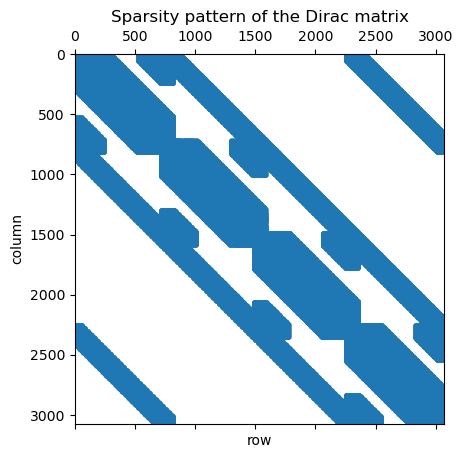

In [13]:
#Sparsity pattern. This could take a couple of seconds 
fig = plt.figure()
plt.spy(Dsparse)
plt.title("Sparsity pattern of the Dirac matrix")
plt.xlabel("row")
plt.ylabel("column")
plt.show()

In [14]:
#150528 for Nx=Ny=Nz=Nt = 4
len(D)

150528

In [15]:
for i in range(100):
    print(row[i],col[i],D[i])

0 0 (5+0j)
0 12 (-0.49999999084738755+1.0523458290707632e-05j)
0 13 (3.397336928496161e-06-2.9467397597629043e-05j)
0 14 (-7.141265084432686e-05-5.533744684119867e-05j)
0 21 (1.0523458290707632e-05+0.49999999084738755j)
0 22 (-2.9467397597629043e-05-3.397336928496161e-06j)
0 23 (-5.533744684119867e-05+7.141265084432686e-05j)
0 36 (-0.4999999894821125+5.833024290791429e-05j)
0 37 (-3.3238540298160056e-05-2.2050404503484887e-05j)
0 38 (-2.8207712979047373e-05+6.876608296668308e-05j)
0 45 (-5.833024290791429e-05-0.4999999894821125j)
0 46 (2.2050404503484887e-05-3.3238540298160056e-05j)
0 47 (-6.876608296668308e-05-2.8207712979047373e-05j)
0 48 (-0.49999989321940236+0.00014973529772591325j)
0 49 (9.857075934838036e-05-0.00012163488025459902j)
0 50 (4.604505973703784e-05+0.00024026764378796235j)
0 57 (-0.49999989321940236+0.00014973529772591325j)
0 58 (9.857075934838036e-05-0.00012163488025459902j)
0 59 (4.604505973703784e-05+0.00024026764378796235j)
0 144 (-0.49999997665675816+3.2515721752